In [1]:
import uproot
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import glob
import awkward
import itertools
import time, sys
import matplotlib.colors
from IPython.display import clear_output
import scipy.optimize as optimization
import multiprocessing as mp
import functools
import mplhep
import boost_histogram as bh
import tqdm
import scipy 

def update_progress(i, nfiles): #progress bar, just for show
    progress = i / nfiles
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "N Files to process = {0} \nProgress: [{1}] {2:.1f}%".format(nfiles, "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

Welcome to JupyROOT 6.24/00


Ok so for tomorrow I need to do two things. For the Other scatters I need to get the S1 areas for the events that have an S1 and add that to the total list of all S1s. For the Others without an S1 I need to change the [] to a 0. For the MS events I need to append the S1 values to the S1 list

In [25]:
thefile  = "/global/cfs/cdirs/lz/users/mwilliams/EFTstuff/SR1/SSeff/Rn220HSList.root"#"/global/cfs/cdirs/lz/users/mwilliams/EFTstuff/SR1/SSeff/Rn220HSList.root" #"/global/cfs/projectdirs/lz/users/sally/UCSB/PFC_Efficiency/SR1/longlist.root"#"/global/project/projectdirs/lz/users/mwilliams/EFTstuff/SR1/SSeff/Rn220HSList.root"  #"/global/project/projectdirs/lz/users/mwilliams/InteractionFinder/SR1/PFCIFdev_DDeff.root""/global/project/projectdirs/lz/users/mwilliams/InteractionFinder/SR1/PFCIFdev_HSeff.root""/global/cfs/projectdirs/lz/users/sally/UCSB/PFC_Efficiency/SR1/longlist.root" 
events = uproot.open(thefile)['Events']
scatters = uproot.open(thefile)['Scatters']
nSS = scatters["ss./ss.nSingleScatters"].array()
nMS = scatters["ms./ms.nMultipleScatters"].array()
nPU = scatters["pileUp./pileUp.nPileUpScatters"].array()
nO = scatters["other./other.nOtherScatters"].array()
OS1s = scatters["other./other.s1PulseIDs"].array()
OS2s = scatters["other./other.s2PulseIDs"].array()
runID = events["eventHeader./eventHeader.runID"].array()
eventID = events["eventHeader./eventHeader.eventID"].array()
SSS1 = scatters["ss./ss.s1Area_phd"].array()
MSS1 = scatters["ms./ms.s1Area_phd"].array()
S1area = events["pulsesTPC./pulsesTPC.pulseArea_phd"].array()

In [26]:
print(list(nSS).count(1))
print(list(nMS).count(1))
print(list(nPU).count(1))
print(list(nO).count(1))

575
2
0
1


In [27]:
isSS = nSS > 0
isMS = nMS > 0
isPU = nPU > 0
isO = nO > 0
islowE = SSS1 < 150

In [28]:
#nSS = nSS[islowE]
#SSS1 = SSS1[islowE]

SSrunID = runID[isSS]
SSeventID = eventID[isSS]
MSrunID = runID[isMS]
MSeventID = eventID[isMS]
MSS1 = MSS1[isMS]
PUrunID = runID[isPU]
PUeventID = eventID[isPU]
OrunID = runID[isO]
OeventID = eventID[isO]
OS1 = OS1s[isO]
OS2 = OS2s[isO]
OS1area = S1area[isO]

In [6]:
MSS1list = [25.050077438354492,10.222650527954102,6.177493095397949,7.957250595092773]

In [7]:
for i,j in zip(MSrunID,MSeventID):
    print(i,j)

7159 173876
7159 308469
7167 338366
7172 374684
7175 492147


In [8]:
for i in MSS1:
    print(i)

7.7683210372924805
10.18354606628418
6.181085109710693
7.974580764770508
7.5758562088012695


3,4,6,7,8,9,10,12,13 were actually MS so there is really only 4 SS called MS

In [9]:
for i,j in zip(OrunID,OeventID):
    print(i,j)

7157 899870
7158 717619
7160 272822
7160 751667
7160 971589
7162 60651
7167 55089
7167 239800
7167 948172
7172 459734
7172 898125
7173 131742
7173 1206940
7175 197348
7177 1125365


In [10]:
OtherS1list = [13.163,5.336,2.867,8.809,3.829,19.065,2.847,3.255,3.764,4.9,3.207,5.044,3.806,7.749,5.199]#[13.163,5.336,3.829,19.065,2.847,3.255,3.764,4.9,3.207,3.806,5.199,2.693,5.933,15.198,14.337,11.738,1.825,2.288] #[13.163,5.336,2.867,8.809,3.829,19.065,2.847,3.255,3.764,4.9,3.207,5.044,3.806,7.749,5.199]

Let's calculate the efficiency as a function of S1

In [66]:
effdev = []
perbin = []
nSSperbin = []
nSSinbin = 0
neventsperbin = 0
S1s = [x for x in SSS1]
#S1s.extend(x for x in MSS1list)
#S1s.extend(x for x in OtherS1list)
S1area=[i for i in S1s if i!= -1]
sortS1 = sorted(S1area)
#SSlist = [1]*1108 + [0]*20
SSlist = [1]*575
sortednSS = [x for _,x in sorted(zip(S1area,SSlist))]
minS1, maxS1, step = 100, 600, 20

In [67]:
for i,(j,k) in enumerate(zip(sortednSS,sortS1)):
    if  k >= minS1 and k < minS1 + step:
        neventsperbin+=1
        if j ==1:
            nSSinbin += 1
        if j ==0:
            nSSinbin += 0
        ratio = nSSinbin/neventsperbin
    if sortS1[i+1] >= minS1 + step:
        minS1 += step
        effdev.append(ratio)
        perbin.append(neventsperbin)
        nSSperbin.append(nSSinbin)
        ratio = 0
        neventsperbin = 0
        nSSinbin = 0
    if sortS1[i+1] > maxS1:
        break


In [68]:
effdev

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [21]:

index_to_change = eff546.index(0)

# Change the value at the found index to 1
eff546[index_to_change] = 1.0

In [69]:
errdev = []
for k,N,eps in zip(nSSperbin,perbin,effdev):
    if k != N:
        error = (((k+1)*(k+2))/((N+2)*(N+3))) - ((k+1)**(2))/((N+2)**(2))
    if k == N:
        error = (N+1)/((N+3)*(N+2)**2)
    errdev.append(np.sqrt(error))

In [23]:
err546

[0.010567087948765753,
 0.009935951504252851,
 0.00985422904621445,
 0.013032087640715943,
 0.0187248735953396,
 0.021733762085414478,
 0.030288230287347492,
 0.03843075691322091,
 0.04755948656056709,
 0.09045340337332909,
 0.0554593553871802,
 0.12371791482634838,
 0.11023963796102461,
 0.14085904245475275,
 0.16329931618554522,
 0.16329931618554522,
 0.28867513459481287,
 0.23570226039551584,
 0.23570226039551584]

In [70]:
errtot = []
errtot = err546 + errdev
#errtot = list(itertools.chain(errtot))

In [71]:
uppererror546 = []

In [72]:
#uppererrordev = [0.01259282491351338, 0.006252559662692057,0.009952965099382557,0.010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#asymmetric_errordev = np.array(list(zip(errdev, uppererrordev))).T
uppererror546 = [0.01414008, 0.01099366, 0.0087,0.010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]+ [0]*26
asymmetric_error546 = np.array(list(zip(errtot, uppererror546))).T

In [78]:
range1 = np.arange(2.5, 99.5, 5)

# Range from 100 to 600 in steps of 20
range2 = np.arange(100, 580, 20)

# Concatenate the two ranges
S1vals = np.concatenate((range1, range2))

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.plot( S1vals, effdev, 'r-o', lw=2, ms=6 )
plt.plot( S1vals, eff546, 'g-o', lw=2, ms=6 )
plt.errorbar(S1vals,effdev,yerr=asymmetric_errordev,xerr=None,color='red',marker='.',linestyle='none',label='LZap_Dev Data')
plt.errorbar(S1vals,eff546,yerr=asymmetric_error546,xerr=None,color='green',marker='.',linestyle='none',label='Lzap_546 Data')
plt.grid(True,which ='major',axis = 'both')
plt.xlim(0,95)
plt.legend(prop={'size': 20})
plt.title('DD SS Selection Efficiency',fontsize=20) 
plt.xlabel('S1c [phd]',fontsize=20) 
plt.ylabel('Efficiency',fontsize=20) 
plt.ylim(0.7,1.01)
plt.yticks(range(0, 1,0.5))
plt.show()

In [74]:
EFTeff = [0.9609756097560975,0.9678571428571429,0.9879518072289156,0.9916666666666667,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0] + [1.0]*24

In [75]:
EFTeff

[0.9609756097560975,
 0.9678571428571429,
 0.9879518072289156,
 0.9916666666666667,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [76]:
print(len(EFTeff))

44


In [77]:
print(len(asymmetric_error546[1]))

44


In [79]:
print(len(S1vals))

44


TypeError: 'float' object cannot be interpreted as an integer

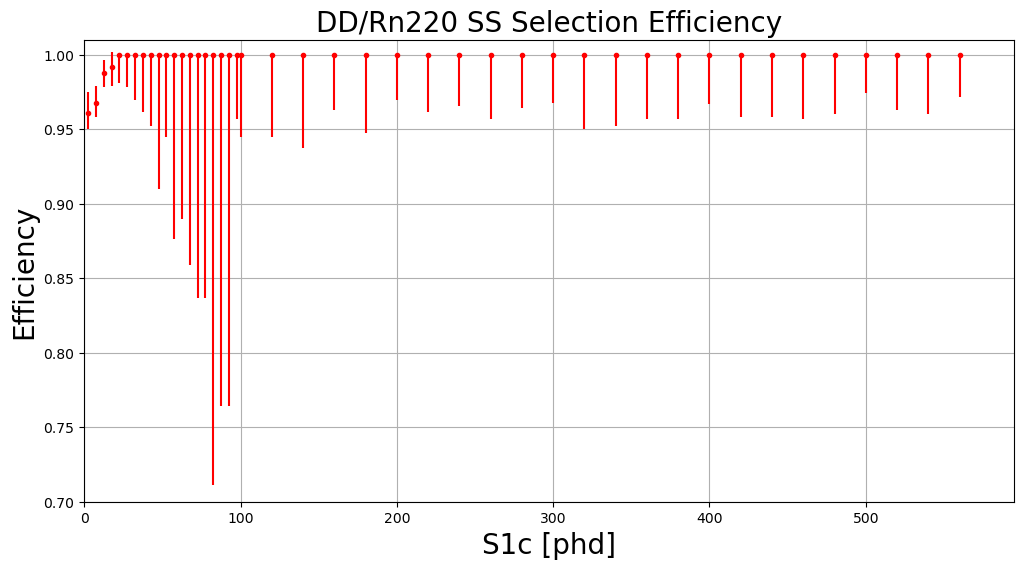

In [80]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.errorbar(S1vals,EFTeff,yerr=asymmetric_error546,xerr=None,color='red',marker='.',linestyle='none')
plt.grid(True,which ='major',axis = 'both')
plt.xlim(0,595)
#plt.legend(prop={'size': 20})
plt.title('DD/Rn220 SS Selection Efficiency',fontsize=20) 
plt.xlabel('S1c [phd]',fontsize=20) 
plt.ylabel('Efficiency',fontsize=20) 
plt.ylim(0.7,1.01)
plt.yticks(range(0, 1,0.5))
plt.show()

In [ ]:
bin_width_x = (600 - 0)/120
h_1d = bh.numpy.histogram(EFTeff,bins = 120,range=(0,600),histogram=bh.Histogram)
#h_1d.fill(EFTeff)


In [ ]:
SSrange = np.arange(2.5,607.5,5)
mplhep.histplot(EFTeff, SSrange)

In [ ]:
"""
save_file = True
hist_iS1 = bh.Histogram(bh.axis.Regular(120, 0, 600))
if save_file:
    file_name = "EFTSSeffFinal"
    file = uproot.recreate(f"/global/cfs/cdirs/lz/users/mwilliams/EFTstuff/SR1/SSeff/{file_name}.root")
    file["h_EFTSSeff"] = np.array(EFTeff).T,hist_iS1.axes[0].edges
    #fig.savefig(f"output/{file_name}.pdf", bbox_inches='tight')
    """

In [ ]:
file_path = '/global/cfs/cdirs/lz/users/mwilliams/EFTstuff/SR1/SSeff/'
file_name = '/EFTSSeffFinal.root'
root_file = uproot.open(file_path+file_name)
root_file.classnames()
testhist = root_file['h_EFTSSeff'].to_hist()

In [ ]:
testhist